# Sampling

In [1]:
import torch
from tqdm import tqdm

from models.early_exit import EarlyExitUViT
from models.uvit import UViT

device = "mps"

betas = torch.linspace(1e-4, 0.02, 1000).to(device)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)
alphas_bar_previous = torch.cat([torch.tensor([1.0], device=device), alphas_bar[:-1]])
betas_tilde = betas * (1 - alphas_bar_previous) / (1 - alphas_bar)


model = UViT(
    img_size=32,
    patch_size=2,
    embed_dim=512,
    depth=12,
    num_heads=8,
    mlp_ratio=4,
    qkv_bias=False,
    mlp_time_embed=False,
    num_classes=-1,
)
model = EarlyExitUViT(model, exit_threshold=float("-inf"))
model.load_state_dict(
    torch.load("./checkpoints/frozen_backbone/4losses.pth", map_location="cpu")[
        "model_state_dict"
    ]
)
model = model.eval()
model = model.to(device)

In [2]:
def sample(threshold):
    torch.manual_seed(0)

    bs = 8
    x = torch.randn(bs, 3, 32, 32).to(device)
    error_prediction_by_timestep = torch.zeros(1000, 13)
    indices_by_timestep = torch.zeros(1000, bs)
    for t in tqdm(range(1000, 0, -1)):
        with torch.no_grad():
            time_tensor = t / 1000 * torch.ones(bs, device=device)
            epsilon, classifier_outputs, outputs = model(x, time_tensor)

        outputs = torch.stack(outputs + [epsilon])
        classifier_outputs = torch.stack(
            classifier_outputs + [torch.zeros_like(classifier_outputs[0])]
        )

        # Simulate early exit with a global threshold
        indices = torch.argmax(classifier_outputs <= threshold, dim=0)
        epsilon = outputs[indices, torch.arange(bs)]

        # Log for visualization
        error_prediction_by_timestep[t - 1] = classifier_outputs.mean(axis=1)[:13]
        indices_by_timestep[t - 1, :] = indices

        alpha_t = alphas[t - 1]
        alpha_bar_t = alphas_bar[t - 1]
        sigma_t = torch.sqrt(betas_tilde[t - 1])

        z = torch.randn_like(x) if t > 1 else 0
        x = (
            torch.sqrt(1 / alpha_t)
            * (x - (1 - alpha_t) / (torch.sqrt(1 - alpha_bar_t)) * epsilon)
        ) + sigma_t * z

    return {
        "samples": x,
        "error_prediction_by_timestep": error_prediction_by_timestep,
        "indices_by_timestep": indices_by_timestep,
    }

In [3]:
results_by_threshold = {
    threshold: sample(threshold) for threshold in (0, 0.025, 0.05, 0.075, 0.1)
}

100%|██████████| 1000/1000 [01:43<00:00,  9.68it/s]


# Classifier output plot

torch.Size([1300, 1000])


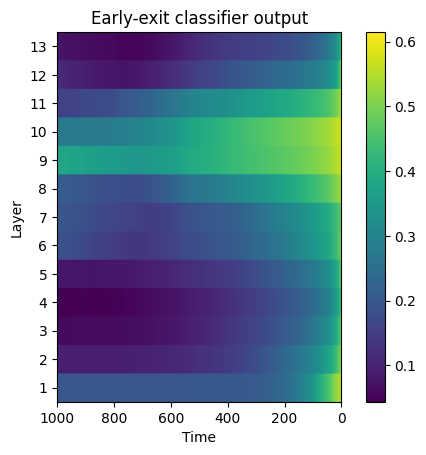

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Make the time be in the "x-axis"
matrix = results_by_threshold[0]["error_prediction_by_timestep"].T
# Make time go from T to 0 and
# make the first layer be down, and the last layer up
matrix = matrix.flip(dims=(0, 1))
# Since the dimensions are (13, 1000), we will repeat each row 100 times
matrix = matrix.repeat_interleave(repeats=100, dim=0)
print(matrix.shape)

plt.title("Early-exit classifier output")
plt.imshow(matrix)

plt.xlabel("Time")
plt.xticks(
    ticks=np.arange(0, 1001, 200),
    labels=np.arange(1000, -1, -200),
)

plt.ylabel("Layer")
plt.yticks(
    ticks=np.arange(100, 1301, 100) - 50,
    labels=np.arange(13, 0, -1),
)

plt.colorbar()
plt.savefig("out_images/classifier_output.svg")

# Early-exit layer plot

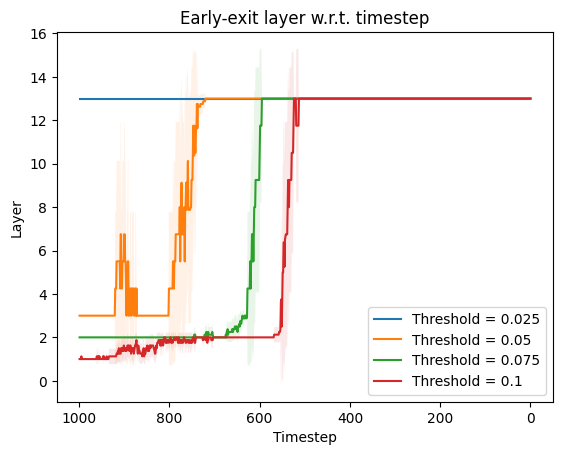

In [33]:
plt.title("Early-exit layer w.r.t. timestep")
time = np.arange(1000, 0, -1)


for threshold, results in results_by_threshold.items():
    if threshold == 0:
        continue
    indices_by_timestep = results["indices_by_timestep"]
    mean = indices_by_timestep.mean(axis=1)
    std = indices_by_timestep.std(axis=1)

    plt.plot(time, mean, label=f"Threshold = {threshold}")
    plt.fill_between(time, mean - std, mean + std, alpha=0.1)

plt.legend()

plt.xlabel("Timestep")
plt.xticks(
    ticks=np.arange(0, 1001, 200),
    labels=np.arange(1000, -1, -200),
)

plt.ylabel("Layer")
plt.savefig("out_images/exit_layer.svg")

# Samples plot

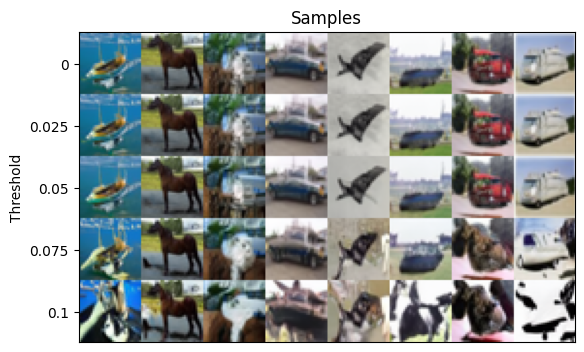

In [36]:
from einops import rearrange

num_thresholds = len(results_by_threshold)

final_image = []
for threshold, results in results_by_threshold.items():
    samples = results["samples"]
    samples = samples.cpu().numpy()
    samples = (samples + 1) / 2
    # Stack samples "horizontally"
    samples = rearrange(samples, "b c h w -> h (b w) c")
    final_image.append(samples)

# Stack vertically
final_image = np.concatenate(final_image)
final_image = np.clip(final_image, 0, 1)

plt.title("Samples")
plt.imshow(final_image)

plt.xticks([], [])

plt.yticks(np.arange(0, 32 * num_thresholds, 32) + 16, results_by_threshold.keys())
plt.ylabel("Threshold")
plt.savefig("out_images/samples.svg")